GPU memory growth enabled
Starting model training and evaluation...


/home/sheldor/anaconda3/envs/finbert/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


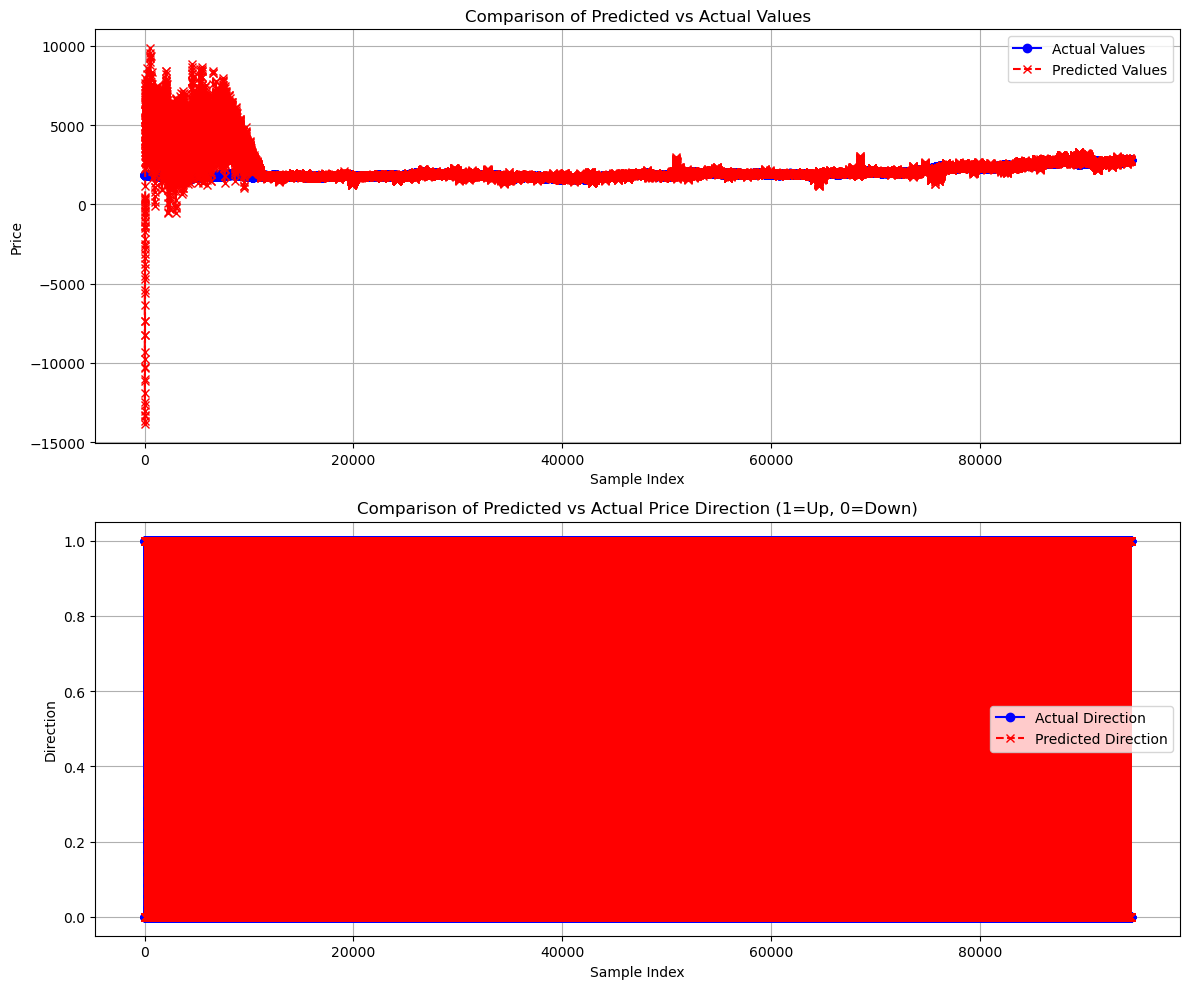

Iteration 1:
MAE: 331.80613389889197
MAPE: 0.18088947939381905
Price Accuracy: 0.819110520606181
Direction Accuracy: 0.49924304180738327


Final Results:
Mean Absolute Error = 331.80613389889197
Mean Absolute Percentage Error = 0.18088947939381905
Price Accuracy = 0.819110520606181
Direction Accuracy = 0.49924304180738327


In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

# Remove mixed precision part since it's causing issues
# from tensorflow.keras import mixed_precision
# mixed_precision.set_global_policy('mixed_float16')

# Configure GPU
def configure_gpu():
    physical_devices = tf.config.list_physical_devices('GPU')
    if len(physical_devices) > 0:
        try:
            for device in physical_devices:
                tf.config.experimental.set_memory_growth(device, True)
            print("GPU memory growth enabled")
        except RuntimeError as e:
            print(e)

# Data preprocessing
def load_and_preprocess_data(file_path, split=0.8, sequence_length=10):
    # Load the dataset
    stock_data = pd.read_csv(file_path, delimiter=";")
    stock_data['Date'] = pd.to_datetime(stock_data['Date'], format='%Y.%m.%d %H:%M')
    stock_data = stock_data.sort_values(by='Date')
    
    # Extract close prices and reshape
    close_prices = stock_data['Close'].values.reshape(-1, 1)
    
    # Split data
    train_examples = int(len(close_prices) * split)
    train = close_prices[:train_examples]
    test = close_prices[train_examples:]
    
    # Scale data
    scaler = MinMaxScaler(feature_range=(0, 1))
    train_scaled = scaler.fit_transform(train)
    test_scaled = scaler.transform(test)
    
    # Create sequences
    X_train, y_train = create_sequences(train_scaled, sequence_length)
    X_test, y_test = create_sequences(test_scaled, sequence_length)
    
    # Reshape for LSTM
    X_train = X_train.reshape((X_train.shape[0], sequence_length, 1))
    X_test = X_test.reshape((X_test.shape[0], sequence_length, 1))
    
    return X_train, y_train, X_test, y_test, scaler, len(train), len(test)

def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i + sequence_length])
        y.append(data[i + sequence_length])
    return np.array(X), np.array(y)

# Model creation
def create_model(sequence_length, learning_rate=0.0001):
    tf.random.set_seed(1234)
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(128, activation="tanh", return_sequences=True, input_shape=(sequence_length, 1)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.LSTM(64, activation="tanh", return_sequences=True),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.LSTM(32, activation="tanh"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(1)
    ])

    model.compile(
        loss='mse',
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        metrics=['mae']
    )
    return model

# Evaluation functions
def calculate_direction_accuracy(actual_values, predicted_values):
    actual_direction = (actual_values[1:] > actual_values[:-1]).astype(int)
    predicted_direction = (predicted_values[1:] > predicted_values[:-1]).astype(int)
    direction_accuracy = np.mean(actual_direction == predicted_direction)
    return direction_accuracy, actual_direction, predicted_direction

def evaluate(predictions, y_test_original):
    mae = mean_absolute_error(y_test_original, predictions)
    mape = mean_absolute_percentage_error(y_test_original, predictions)
    dir_acc, actual_dir, pred_dir = calculate_direction_accuracy(y_test_original, predictions)

    # Plotting
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    
    ax1.plot(y_test_original, label="Actual Values", color="blue", marker='o')
    ax1.plot(predictions, label="Predicted Values", color="red", linestyle='dashed', marker='x')
    ax1.set_title("Comparison of Predicted vs Actual Values")
    ax1.set_xlabel("Sample Index")
    ax1.set_ylabel("Price")
    ax1.legend()
    ax1.grid(True)

    ax2.plot(actual_dir, label="Actual Direction", color="blue", marker='o')
    ax2.plot(pred_dir, label="Predicted Direction", color="red", linestyle='dashed', marker='x')
    ax2.set_title("Comparison of Predicted vs Actual Price Direction (1=Up, 0=Down)")
    ax2.set_xlabel("Sample Index")
    ax2.set_ylabel("Direction")
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

    return mae, mape, (1 - mape), dir_acc

def run_model(X_train, y_train, X_test, y_test, scaler, n_iterations=1, sequence_length=10):
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-6
        )
    ]

    batch_size = 32
    train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size).prefetch(tf.data.AUTOTUNE)

    test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
    test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    total_mae = total_mape = total_acc = total_dir_acc = 0
    results = np.zeros((len(y_test), 1))

    for iteration in range(n_iterations):
        model = create_model(sequence_length)
        
        for j in range(len(y_test)):
            current_input = X_test[j:j+1]
            prediction = model.predict(current_input, verbose=0)
            results[j] = scaler.inverse_transform(prediction.reshape(-1, 1))

            if j < len(y_test) - 1:
                actual = y_test[j].reshape(1, 1)
                model.fit(current_input, actual, epochs=20, verbose=0)

        y_test_original = scaler.inverse_transform(y_test)
        mae, mape, acc, dir_acc = evaluate(results, y_test_original)
        
        total_mae += mae
        total_mape += mape
        total_acc += acc
        total_dir_acc += dir_acc

        print(f"Iteration {iteration + 1}:")
        print(f"MAE: {mae}")
        print(f"MAPE: {mape}")
        print(f"Price Accuracy: {acc}")
        print(f"Direction Accuracy: {dir_acc}\n")

    return (total_mae/n_iterations), (total_mape/n_iterations), (total_acc/n_iterations), (total_dir_acc/n_iterations), results.tolist()

# Main execution
if __name__ == "__main__":
    # Configure GPU
    configure_gpu()

    # Parameters
    FILE_PATH = "XAU_15m_data.csv"
    SPLIT = 0.8
    SEQUENCE_LENGTH = 60
    N_ITERATIONS = 1

    # Load and preprocess data
    X_train, y_train, X_test, y_test, scaler, len_train, len_test = load_and_preprocess_data(
        FILE_PATH, SPLIT, SEQUENCE_LENGTH
    )

    print("Starting model training and evaluation...")
    mae, mape, acc, dir_acc, preds = run_model(
        X_train, y_train, X_test, y_test, scaler, 
        n_iterations=N_ITERATIONS, 
        sequence_length=SEQUENCE_LENGTH
    )

    print("\nFinal Results:")
    print(f"Mean Absolute Error = {mae}")
    print(f"Mean Absolute Percentage Error = {mape}")
    print(f"Price Accuracy = {acc}")
    print(f"Direction Accuracy = {dir_acc}")


Final Results:
Mean Absolute Error = 331.80613389889197
Mean Absolute Percentage Error = 0.18088947939381905
Price Accuracy = 0.819110520606181
Direction Accuracy = 0.49924304180738327


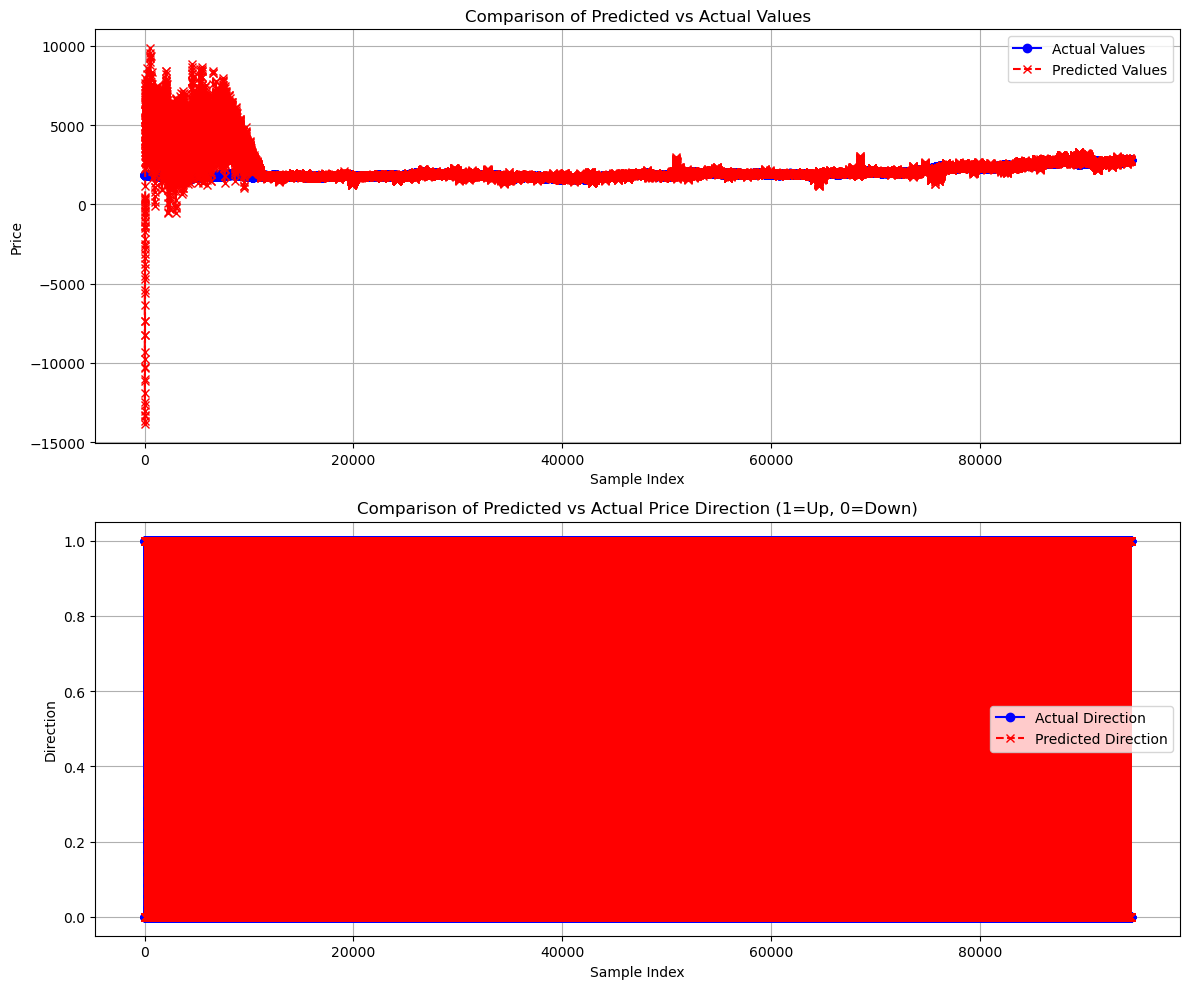

(331.80613389889197,
 0.18088947939381905,
 0.819110520606181,
 0.49924304180738327)

In [10]:
print("\nFinal Results:")
print(f"Mean Absolute Error = {mae}")
print(f"Mean Absolute Percentage Error = {mape}")
print(f"Price Accuracy = {acc}")
print(f"Direction Accuracy = {dir_acc}")
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))
preds = np.array(preds)

evaluate(preds, y_test_original)

In [9]:
print(f"y_test_original shape: {y_test_original.shape}, type: {type(y_test_original)}")
preds = np.array(preds)
print(f"predictions shape: {preds.shape}, type: {type(preds)}")

y_test_original shape: (94458,), type: <class 'numpy.ndarray'>
predictions shape: (94458, 1), type: <class 'numpy.ndarray'>


In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

def calculate_direction_accuracy(actual_values, predicted_values):
    # Ensure inputs are NumPy arrays
    actual_values = np.array(actual_values).flatten()
    predicted_values = np.array(predicted_values).flatten()
    
    # Calculate direction (1 for upward, 0 for downward)
    actual_direction = (actual_values[1:] > actual_values[:-1]).astype(int)
    predicted_direction = (predicted_values[1:] > predicted_values[:-1]).astype(int)
    
    # Calculate direction accuracy
    direction_accuracy = np.mean(actual_direction == predicted_direction)
    return direction_accuracy, actual_direction, predicted_direction

def evaluate(predictions, y_test_original):
    # Calculate metrics
    mae = mean_absolute_error(y_test_original, predictions)
    mape = mean_absolute_percentage_error(y_test_original, predictions)
    dir_acc, actual_dir, pred_dir = calculate_direction_accuracy(y_test_original, predictions)
    
    # Plotting
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    
    ax1.plot(y_test_original, label="Actual Values", color="blue", marker='o')
    ax1.plot(predictions, label="Predicted Values", color="red", linestyle='dashed', marker='x')
    ax1.set_title("Comparison of Predicted vs Actual Values")
    ax1.set_xlabel("Sample Index")
    ax1.set_ylabel("Price")
    ax1.legend()
    ax1.grid(True)

    ax2.plot(actual_dir, label="Actual Direction", color="blue", marker='o')
    ax2.plot(pred_dir, label="Predicted Direction", color="red", linestyle='dashed', marker='x')
    ax2.set_title("Comparison of Predicted vs Actual Price Direction (1=Up, 0=Down)")
    ax2.set_xlabel("Sample Index")
    ax2.set_ylabel("Direction")
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

    return mae, mape, (1 - mape), dir_acc

# Example usage
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
predictions = preds.flatten()

mae, mape, acc, dir_acc = evaluate(predictions, y_test_original)

print("\nFinal Results:")
print(f"Mean Absolute Error = {mae}")
print(f"Mean Absolute Percentage Error = {mape}")
print(f"Price Accuracy = {acc}")
print(f"Direction Accuracy = {dir_acc}")

AttributeError: 'list' object has no attribute 'flatten'